#### https://ekdud7667.tistory.com/entry/KNN-CFCollaborative-Filtering-%EA%B5%AC%ED%98%84

# 1. Data

In [29]:
import pandas as pd
import numpy as np

dir_path = "datas/movielens_small/{}"
rating_data = pd.read_csv(dir_path.format("ratings.csv"))
movie_data = pd.read_csv(dir_path.format("movies.csv"))

In [30]:
crow, ccol = rating_data.shape
print("Rating Data")
print("[count] row : {}, column : {}".format(crow, ccol))
rating_data.head()

Rating Data
[count] row : 100004, column : 4


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [31]:
crow, ccol = movie_data.shape
print("Movie Data")
print("[count] row : {}, column : {}".format(crow, ccol))
movie_data.head()

Movie Data
[count] row : 9125, column : 3


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
# merge data
merge_data = pd.merge(
                rating_data.drop("timestamp", axis=1), movie_data.drop('genres', axis=1), 
                how='outer', on='movieId')[['userId', 'movieId', 'rating']]
crow, ccol = merge_data.shape
print("Merge Data : Left Outer Join, User - Movie")
print("[count] row : {}, column : {}".format(crow, ccol))
merge_data.head()

Merge Data : Left Outer Join, User - Movie
[count] row : 100063, column : 3


,userId,movieId,rating
0,1.0,31,2.5
1,7.0,31,3.0
2,31.0,31,4.0
3,32.0,31,4.0
4,36.0,31,3.0


Explicit Feedback으로 분류되는 평점 데이터는 대부분 인기가 많은 영화들로, long tail과 같은 분포를 따른다.


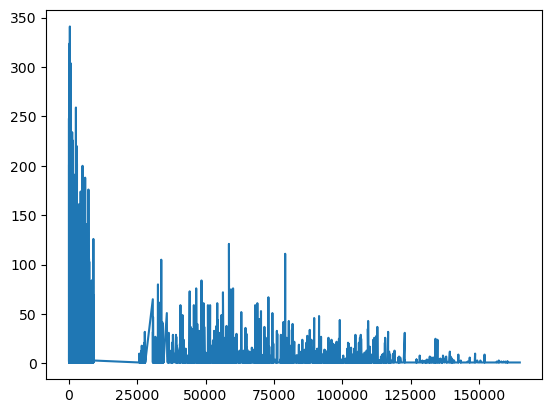

In [65]:
# Analsys : Distribute Check
import matplotlib.pyplot as plt

movie_ids = merge_data['movieId']
count_group = merge_data['movieId'].groupby(movie_ids).count()
movie_id, count = count_group.index, count_group.values

print("Explicit Feedback으로 분류되는 평점 데이터는 대부분 인기가 많은 영화들로, long tail과 같은 분포를 따른다.")

plt.plot(movie_id, count)
plt.show()

# 2. Data Preprocessing

In [66]:
# Pivotting
usr_movie_features = rating_data.pivot(index="userId", columns="movieId", values="rating").fillna(0)

usr_movie_features.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
# convert matrix
mat = usr_movie_features.to_numpy()

print("matrix size : {}".format(mat.shape))

matrix size : (671, 9066)


# 3. Model Setting

In [262]:
from sklearn.neighbors import NearestNeighbors

metric = "cosine"
algorithm = "auto"
n_negihbors = 10
n_jobs = 10

knn = NearestNeighbors(
            metric=metric, 
            algorithm=algorithm, 
            n_neighbors=n_negihbors, 
            n_jobs=n_jobs)
knn.fit(mat)

# row - user idx, col - 유사도 결과값, 이웃들의 index
similarity_values, usr_neighbors = knn.kneighbors()

# 4. Analysis

In [264]:
# 나의 이웃들은 어떤 영화를 시청하고 있을까?
target_user_id = 151
# knn이 반환하는 similarity_values, usr_neighbors는 zero-index
target_user_idx = target_user_id - 1

target_user_ratings = usr_movie_features.loc[target_user_id].values
target_user_neighbors = usr_neighbors[target_user_idx]

print("user neighbors : {}".format(",".join(target_user_neighbors.astype(str).tolist())))

user neighbors : 368,399,278,49,143,144,534,193,160,661


## Best-Case 

In [274]:
# 가장 유사했던 이웃 (가장 클수록 유사함)
neighbor_idx = target_user_neighbors[n_negihbors - 1]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가장 가까운 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가장 가까운 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가장 가까운 이웃과 나는 ----
-- 45개의 영화를 똑같이 시청하셨어요!
1.Jumanji (1995)
2.GoldenEye (1995)
3.Ace Ventura: When Nature Calls (1995)
4.Babe (1995)
5.Clueless (1995)
6.Seven (a.k.a. Se7en) (1995)
7.Apollo 13 (1995)
8.Die Hard: With a Vengeance (1995)
9.Net, The (1995)
10.Waterworld (1995)
...

나와 가장 가까운 이웃은 ----
19개의 영화도 추가로 시청하셨습니다!

1.Get Shorty (1995)
2.Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3.Usual Suspects, The (1995)
4.Broken Arrow (1996)
5.Braveheart (1995)
6.Batman Forever (1995)
7.Congo (1995)
8.Crimson Tide (1995)
9.Judge Dredd (1995)
10.Interview with the Vampire: The Vampire Chronicles (1994)
...



In [275]:
# 가장 유사도가 떨어지는 이웃
neighbor_idx = target_user_neighbors[0]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가까운 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가까운 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가까운 이웃과 나는 ----
-- 49개의 영화를 똑같이 시청하셨어요!
1.Jumanji (1995)
2.GoldenEye (1995)
3.Get Shorty (1995)
4.Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
5.Clueless (1995)
6.Seven (a.k.a. Se7en) (1995)
7.Usual Suspects, The (1995)
8.Braveheart (1995)
9.Apollo 13 (1995)
10.Batman Forever (1995)
...

나와 가까운 이웃은 ----
15개의 영화도 추가로 시청하셨습니다!

1.Ace Ventura: When Nature Calls (1995)
2.Babe (1995)
3.Broken Arrow (1996)
4.Congo (1995)
5.Crimson Tide (1995)
6.Judge Dredd (1995)
7.Disclosure (1994)
8.Dumb & Dumber (Dumb and Dumber) (1994)
9.Legends of the Fall (1994)
10.Quiz Show (1994)
...



## Worst-Case

In [272]:
# KNN은 아래와 같이 코사인 유사도 방식으로 동작한다.
from sklearn.metrics.pairwise import cosine_similarity as cos

target_ratings = usr_movie_features.loc[target_user_id].values
target_ratings = np.expand_dims(target_ratings, axis=0)

all_ratings = usr_movie_features.to_numpy()
similarity_values = cos(target_ratings, all_ratings)[0]

sort_index = similarity_values.argsort()

neighbor_idx = sort_index[0]
neighbor_id = neighbor_idx + 1

# 평점 데이터
target_data = rating_data[rating_data['userId'] == target_user_id]
neighbor_data = rating_data[rating_data['userId'] == neighbor_id]

# 영화 리스트
target_movies = pd.merge(target_data, movie_data, how="inner", on="movieId")['title'].values
neighbor_movies = pd.merge(neighbor_data, movie_data, how="inner", on="movieId")['title'].values

# 똑같이 시청한 영화 리스트
condition = np.isin(target_movies, neighbor_movies)
same_see = target_movies[condition]
print("나와 가장 가까웃 이웃과 나는 ----")
print("-- {}개의 영화를 똑같이 시청하셨어요!".format(same_see.size))
for idx, title in enumerate(same_see[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if same_see.size > 10 else "\n")

# 아직 시청하지 않은 영화 리스트 (추천 영화 리스트)
reco_movies = target_movies[~condition]
print("나와 가장 가까웃 이웃은 ----")
print("{}개의 영화도 추가로 시청하셨습니다!\n".format(reco_movies.size))
for idx, title in enumerate(reco_movies[:10]):
    print("{}.{}".format(idx + 1, title))
print("...\n" if reco_movies.size > 10 else "\n")

나와 가장 가까웃 이웃과 나는 ----
-- 0개의 영화를 똑같이 시청하셨어요!


나와 가장 가까웃 이웃은 ----
64개의 영화도 추가로 시청하셨습니다!

1.Jumanji (1995)
2.GoldenEye (1995)
3.Ace Ventura: When Nature Calls (1995)
4.Get Shorty (1995)
5.Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
6.Babe (1995)
7.Clueless (1995)
8.Seven (a.k.a. Se7en) (1995)
9.Usual Suspects, The (1995)
10.Broken Arrow (1996)
...

